In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 1000

option_compute_ktable =1

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 20

data w_diffuse
     &     /1.5 , 1.5 , 1.5 , 1.5,
     &     1.5 , 1.5 , 1.5 , 1.5,
     &     1.5 , 1.5/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.65 , 0.65,
     &     0.65 , 0.65/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

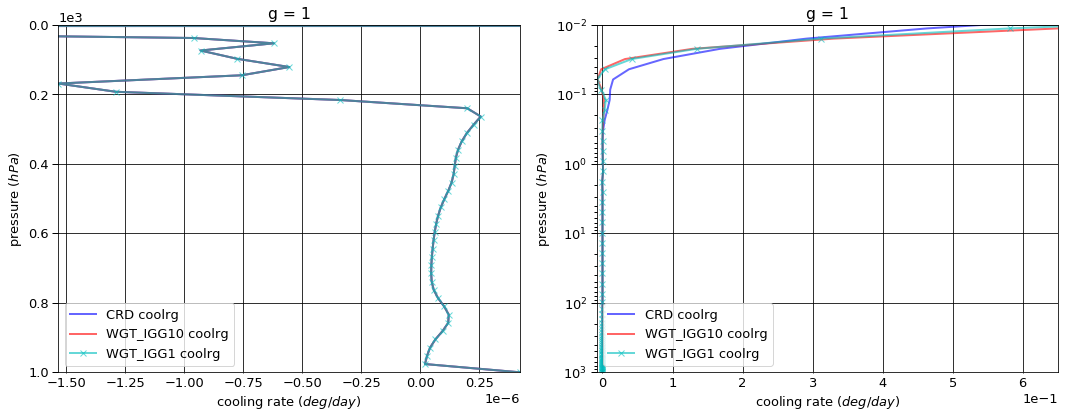

# Figure: cooling rate g-group 2

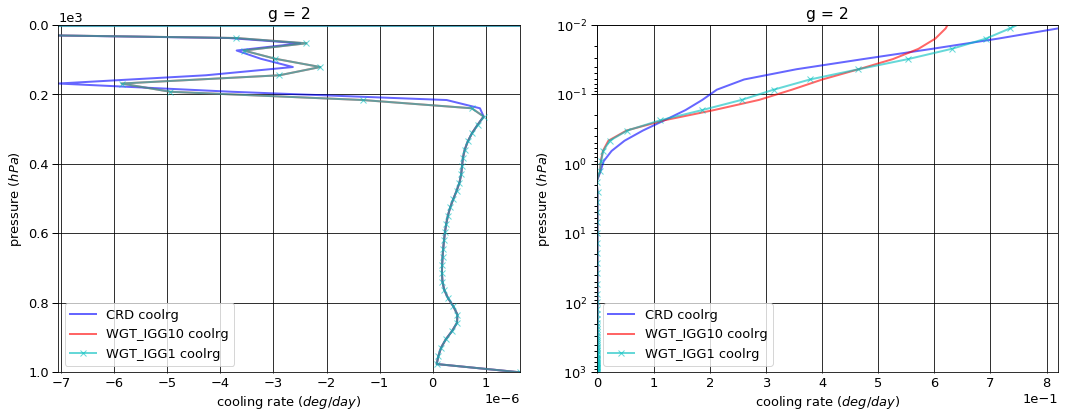

# Figure: cooling rate g-group 3

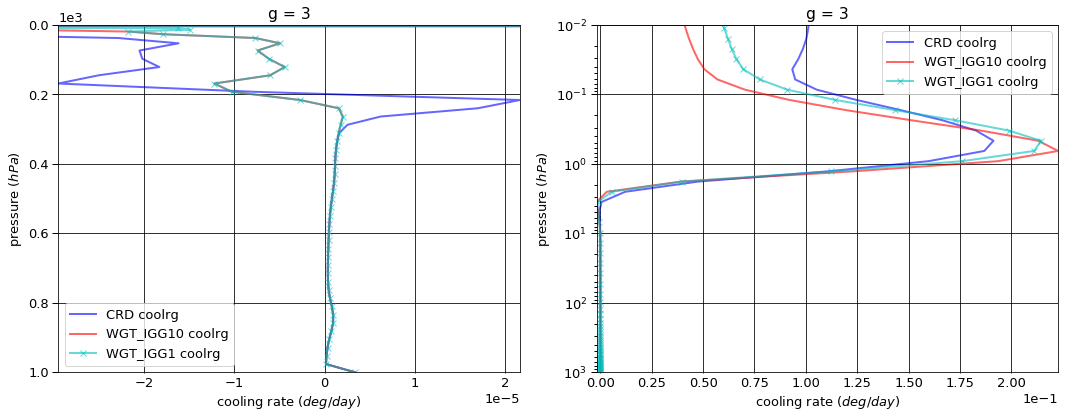

# Figure: cooling rate g-group 4

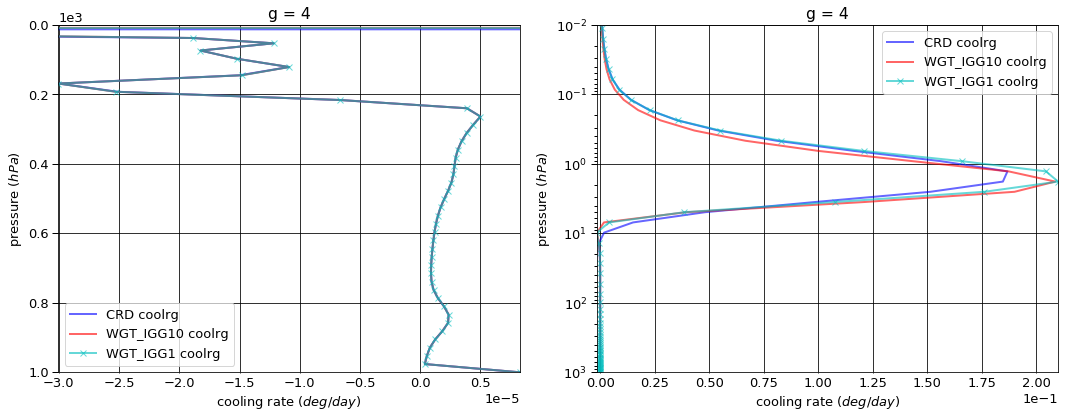

# Figure: cooling rate g-group 5

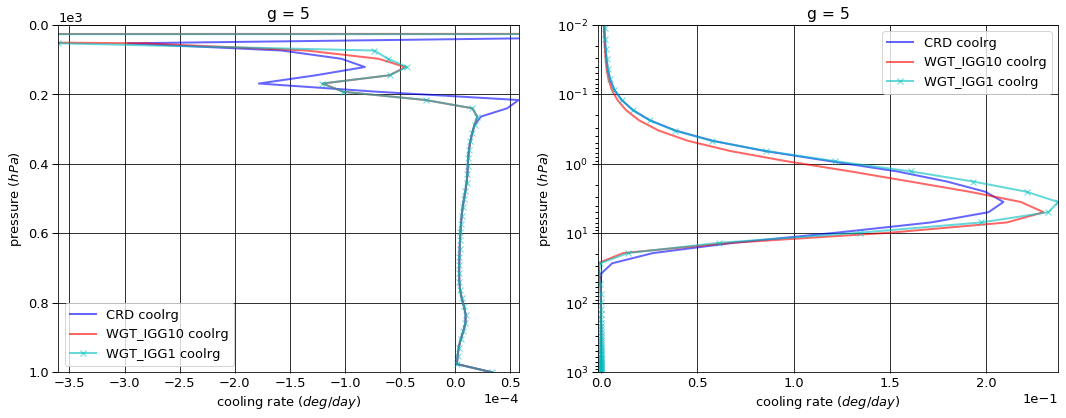

# Figure: cooling rate g-group 6

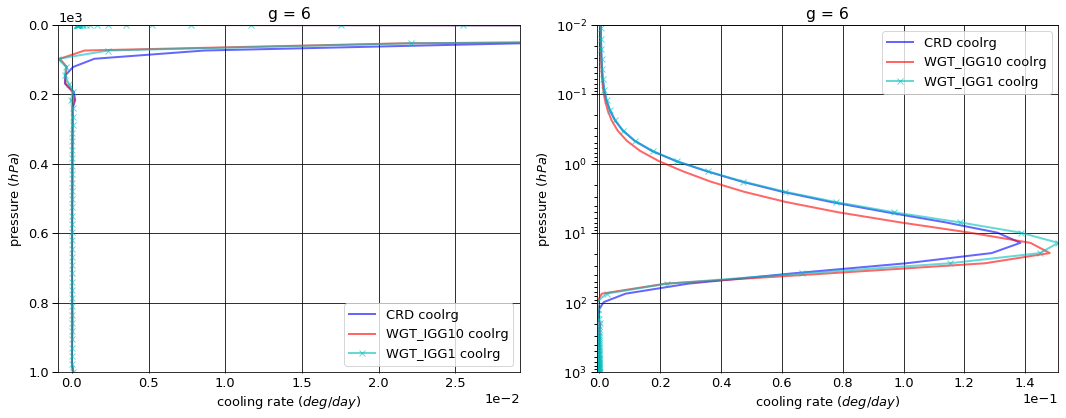

# Figure: cooling rate g-group 7

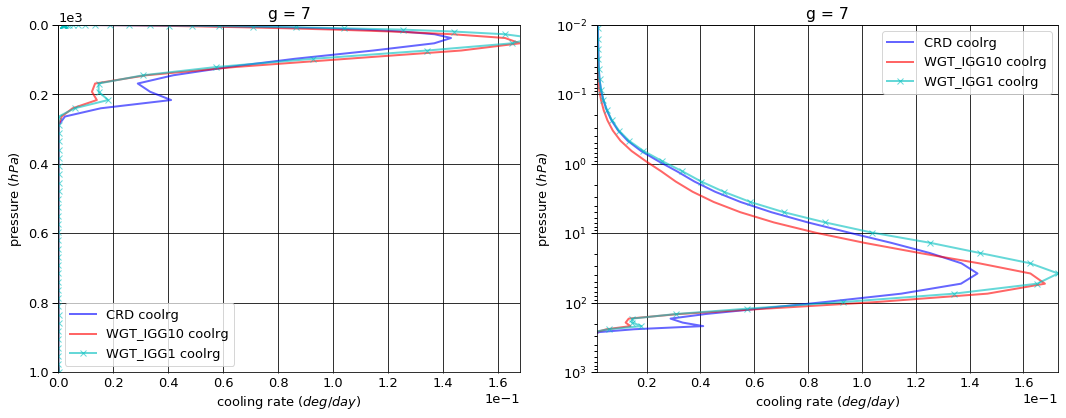

# Figure: cooling rate g-group 8

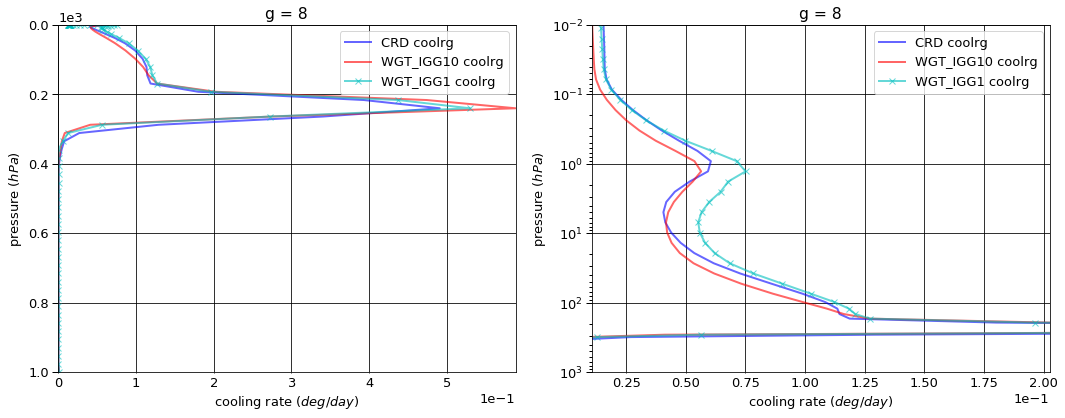

# Figure: cooling rate g-group 9

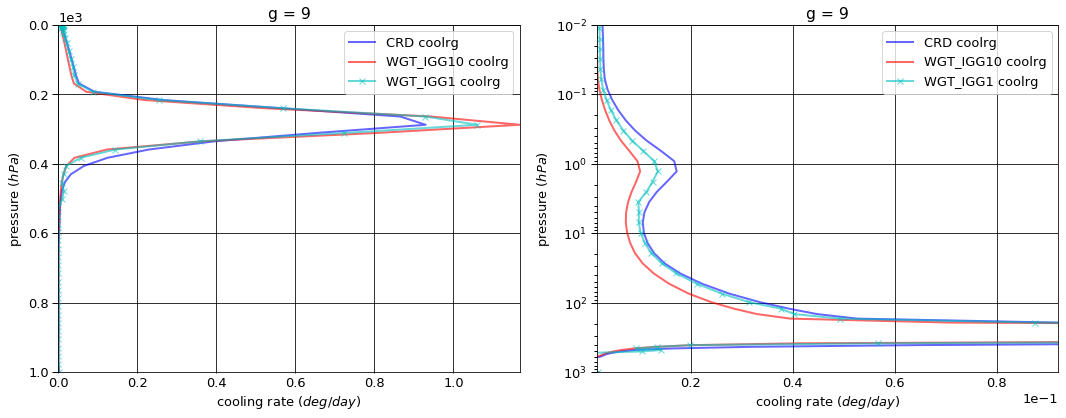

# Figure: cooling rate g-group 10

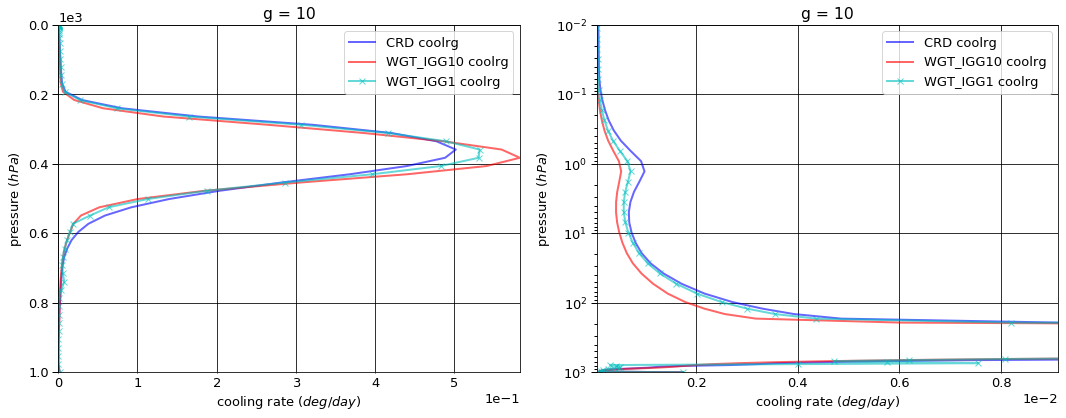

# Figure: cooling rate g-group total

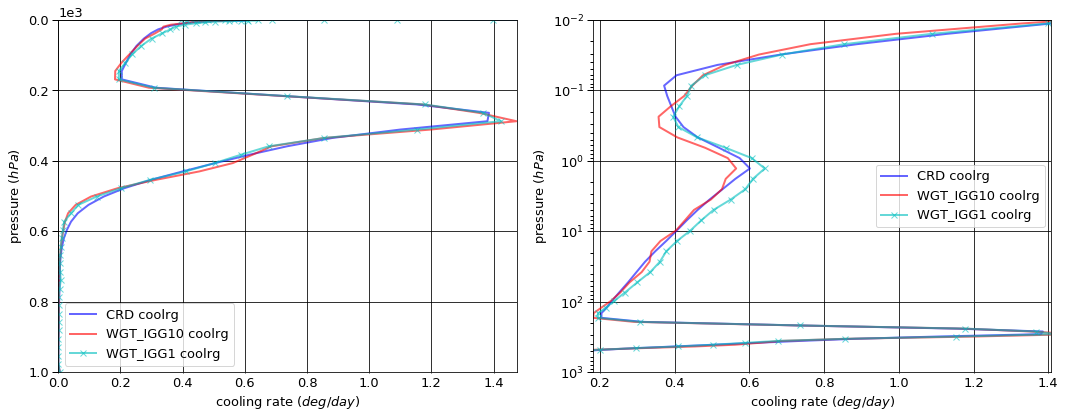

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002777   0.000000  -0.002777
   1013.0   76     -0.004798   0.004797  -0.000001
2  0.0      1      -0.011183   0.000000  -0.011183
   1013.0   76     -0.017640   0.017636  -0.000005
3  0.0      1      -0.030694   0.000000  -0.030694
   1013.0   76     -0.037953   0.037943  -0.000009
4  0.0      1      -0.076964   0.000000  -0.076964
   1013.0   76     -0.093498   0.093475  -0.000023
5  0.0      1      -0.276238   0.000000  -0.276238
   1013.0   76     -0.374613   0.374520  -0.000092
6  0.0      1      -0.592502   0.000000  -0.592502
   1013.0   76     -0.905934   0.905712  -0.000222
7  0.0      1      -2.103966   0.000000  -2.103966
   1013.0   76     -3.445474   3.444629  -0.000845
8  0.0      1      -6.496473   0.000000  -6.496473
   1013.0   76    -10.362046  10.359491  -0.002554
9  0.0      1     -12.705748   0.000000 -12.705748
   1013.0   76    -18.975218  18.970421  -0.004798
10 0.0      1     -11.936137   0.000000 -11.936137
   1013.0   76    -16.856257  16.851464  -0.004793


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002760   0.000000  -0.002760
   1013.0   76     -0.004798   0.004797  -0.000001
2  0.0      1      -0.010863   0.000000  -0.010863
   1013.0   76     -0.017640   0.017636  -0.000005
3  0.0      1      -0.031113   0.000000  -0.031113
   1013.0   76     -0.037953   0.037943  -0.000009
4  0.0      1      -0.077725   0.000000  -0.077725
   1013.0   76     -0.093498   0.093475  -0.000023
5  0.0      1      -0.278009   0.000000  -0.278009
   1013.0   76     -0.374613   0.374520  -0.000092
6  0.0      1      -0.592932   0.000000  -0.592932
   1013.0   76     -0.905934   0.905712  -0.000222
7  0.0      1      -2.094908   0.000000  -2.094908
   1013.0   76     -3.445474   3.444629  -0.000845
8  0.0      1      -6.456551   0.000000  -6.456551
   1013.0   76    -10.362046  10.359491  -0.002554
9  0.0      1     -12.677032   0.000000 -12.677032
   1013.0   76    -18.975218  18.970421  -0.004798
10 0.0      1     -11.952457   0.000000 -11.952457
   1013.0   76    -16.856257  16.851475  -0.004781


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002758   0.000000  -0.002758
   1013.0   76     -0.004798   0.004797  -0.000001
2  0.0      1      -0.010834   0.000000  -0.010834
   1013.0   76     -0.017640   0.017636  -0.000005
3  0.0      1      -0.030816   0.000000  -0.030816
   1013.0   76     -0.037953   0.037943  -0.000009
4  0.0      1      -0.077786   0.000000  -0.077786
   1013.0   76     -0.093498   0.093475  -0.000023
5  0.0      1      -0.279596   0.000000  -0.279596
   1013.0   76     -0.374613   0.374520  -0.000092
6  0.0      1      -0.596347   0.000000  -0.596347
   1013.0   76     -0.905934   0.905712  -0.000222
7  0.0      1      -2.105158   0.000000  -2.105158
   1013.0   76     -3.445474   3.444629  -0.000845
8  0.0      1      -6.449980   0.000000  -6.449980
   1013.0   76    -10.362046  10.359491  -0.002554
9  0.0      1     -12.630781   0.000000 -12.630781
   1013.0   76    -18.975218  18.970421  -0.004798
10 0.0      1     -11.896408   0.000000 -11.896408
   1013.0   76    -16.856257  16.851475  -0.004781


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.629410e-05  0.000000e+00  1.629410e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1      3.198110e-04  0.000000e+00  3.198110e-04
   1013.0   76     0.000000e+00  0.000000e+00 -8.470329e-22
3  0.0      1     -4.189960e-04  0.000000e+00 -4.189960e-04
   1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
4  0.0      1     -7.602570e-04  0.000000e+00 -7.602570e-04
   1013.0   76     1.387779e-17  0.000000e+00  0.000000e+00
5  0.0      1     -1.770290e-03  0.000000e+00 -1.770290e-03
   1013.0   76     0.000000e+00  5.551115e-17  0.000000e+00
6  0.0      1     -4.303100e-04  0.000000e+00 -4.303100e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      9.057900e-03  0.000000e+00  9.057900e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      3.992190e-02  0.000000e+00  3.992190e-02
   1013.0   76     1.776357e-15  0.000000e+00  0.000000e+00
9  0.0      1      2.871600e-02  0.000000e+00  2.871600e-02
   1013.0   76    -3.552714e-15  3.552714e-15 -8.673617e-19
10 0.0      1     -1.632000e-02  0.000000e+00 -1.632000e-02
   1013.0   76     0.000000e+00  1.100000e-05  1.159800e-05


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.886940e-05  0.000000e+00  1.886940e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1      3.487160e-04  0.000000e+00  3.487160e-04
   1013.0   76     0.000000e+00  0.000000e+00 -8.470329e-22
3  0.0      1     -1.221810e-04  0.000000e+00 -1.221810e-04
   1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
4  0.0      1     -8.212090e-04  0.000000e+00 -8.212090e-04
   1013.0   76     1.387779e-17  0.000000e+00  0.000000e+00
5  0.0      1     -3.357550e-03  0.000000e+00 -3.357550e-03
   1013.0   76     0.000000e+00  5.551115e-17  0.000000e+00
6  0.0      1     -3.844830e-03  0.000000e+00 -3.844830e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1     -1.192400e-03  0.000000e+00 -1.192400e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      4.649240e-02  0.000000e+00  4.649240e-02
   1013.0   76     1.776357e-15  0.000000e+00  0.000000e+00
9  0.0      1      7.496700e-02  0.000000e+00  7.496700e-02
   1013.0   76    -3.552714e-15  3.552714e-15 -8.673617e-19
10 0.0      1      3.972900e-02  0.000000e+00  3.972900e-02
   1013.0   76     0.000000e+00  1.100000e-05  1.159800e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      5.211350e+00
   1001.112500 75     4.215479e-07
2  0.000312    1      1.219167e+00
   1001.112500 75     1.642620e-06
3  0.000312    1      9.355681e-02
   1001.112500 75     3.374864e-06
4  0.000312    1      6.765906e-05
   1001.112500 75     8.270525e-06
5  0.000312    1      9.025177e-04
   1001.112500 75     3.332748e-05
6  0.000312    1      3.142795e-04
   1001.112500 75     8.013777e-05
7  0.000312    1      1.652537e-03
   1001.112500 75     3.057159e-04
8  0.000312    1      1.348389e-02
   1001.112500 75     9.237765e-04
9  0.000312    1      2.281942e-03
   1001.112500 75     1.735009e-03
10 0.000312    1      5.614973e-05
   1001.112500 75     1.733303e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      3.286066e+00
   1001.112500 75     4.215479e-07
2  0.000312    1      5.997400e-01
   1001.112500 75     1.642620e-06
3  0.000312    1      3.237331e-02
   1001.112500 75     3.374864e-06
4  0.000312    1      4.369016e-05
   1001.112500 75     8.270525e-06
5  0.000312    1      8.033396e-04
   1001.112500 75     3.332748e-05
6  0.000312    1      2.523682e-04
   1001.112500 75     8.013777e-05
7  0.000312    1      1.228333e-03
   1001.112500 75     3.057159e-04
8  0.000312    1      9.457600e-03
   1001.112500 75     9.237765e-04
9  0.000312    1      1.270006e-03
   1001.112500 75     1.735009e-03
10 0.000312    1      2.688279e-05
   1001.112500 75     1.728557e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      4.065712e+00
   1001.112500 75     4.215479e-07
2  0.000312    1      8.191277e-01
   1001.112500 75     1.642620e-06
3  0.000312    1      4.848670e-02
   1001.112500 75     3.374864e-06
4  0.000312    1      5.706260e-05
   1001.112500 75     8.270525e-06
5  0.000312    1      9.942774e-04
   1001.112500 75     3.332748e-05
6  0.000312    1      3.188706e-04
   1001.112500 75     8.013777e-05
7  0.000312    1      1.580789e-03
   1001.112500 75     3.057159e-04
8  0.000312    1      1.264101e-02
   1001.112500 75     9.237765e-04
9  0.000312    1      1.747889e-03
   1001.112500 75     1.735009e-03
10 0.000312    1      3.837565e-05
   1001.112500 75     1.728557e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.925285e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -6.194268e-01
   1001.112500 75    -2.117582e-22
3  0.000312    1     -6.118350e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -2.396891e-05
   1001.112500 75     0.000000e+00
5  0.000312    1     -9.917813e-05
   1001.112500 75     0.000000e+00
6  0.000312    1     -6.191134e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -4.242038e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -4.026289e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -1.011935e-03
   1001.112500 75     0.000000e+00
10 0.000312    1     -2.926694e-05
   1001.112500 75    -4.746400e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.145638e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.000391e-01
   1001.112500 75    -2.117582e-22
3  0.000312    1     -4.507011e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.059646e-05
   1001.112500 75     0.000000e+00
5  0.000312    1      9.175971e-05
   1001.112500 75     0.000000e+00
6  0.000312    1      4.591110e-06
   1001.112500 75     0.000000e+00
7  0.000312    1     -7.174790e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -8.428800e-04
   1001.112500 75     0.000000e+00
9  0.000312    1     -5.340530e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.777408e-05
   1001.112500 75    -4.746400e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.232682,0.000000,-34.232682
1013.0,76,-51.073429,51.060087,-0.013342



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.174350,0.000000,-34.174350
1013.0,76,-51.073429,51.060098,-0.013331



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.080465,0.000000,-34.080465
1013.0,76,-51.073429,51.060098,-0.013331



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.058332,0.000000,0.058332
1013.0,76,0.000000,0.000011,0.000012



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.152218,0.000000,0.152218
1013.0,76,0.000000,0.000011,0.000012


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,6.542833
1001.112500,75,0.004825



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,3.931261
1001.112500,75,0.004820



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,4.950705
1001.112500,75,0.004820



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.611572
1001.112500,75,-0.000005



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.592128
1001.112500,75,-0.000005


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000109,0.000096
2,0.000341,0.000347
3,0.000884,0.000756
4,0.002078,0.001866
5,0.008837,0.007466
6,0.020303,0.018083
7,0.082453,0.068721
8,0.239828,0.206379
9,0.400194,0.375115


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.441550e-16
2,3.621082e-17
3,3.809979e-18
4,9.034937e-18
5,9.970460e-19
6,9.178721e-19
7,1.059911e-19
8,1.223930e-20
9,1.413330e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.441550e-16,NaN,0.000109,0.000096,0.000109,0.000096,1.0
2,3.621082e-17,0.105217,0.000341,0.000347,0.000450,0.000443,1.0
3,3.809979e-18,0.105217,0.000884,0.000756,0.001334,0.001199,1.0
4,9.034937e-18,2.371387,0.002078,0.001866,0.003413,0.003066,30.0
5,9.970460e-19,0.110355,0.008837,0.007466,0.012250,0.010531,30.0
6,9.178721e-19,0.920592,0.020303,0.018083,0.032553,0.028615,300.0
7,1.059911e-19,0.115475,0.082453,0.068721,0.115006,0.097336,300.0
8,1.223930e-20,0.115475,0.239828,0.206379,0.354834,0.303715,300.0
9,1.413330e-21,0.115475,0.400194,0.375115,0.755028,0.678830,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
